In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# --- PHẦN 1: CẤU HÌNH ĐƯỜNG DẪN FILE ---
file_path = "/kaggle/input/online-retail-ii-uci/online_retail_II.csv"

# --- PHẦN 2: CÁC CLASS XỬ LÝ (Đã sửa lại đúng chuẩn) ---

class DataCleaner:
    def __init__(self, df):
        self.df = df

    def clean_data(self):
        print("Đang làm sạch dữ liệu...")
        self.df.rename(columns={'Invoice': 'InvoiceNo', 'Customer ID': 'CustomerID', 'Price': 'UnitPrice'}, inplace=True)
        
        # Chuyển InvoiceNo sang chuỗi
        self.df['InvoiceNo'] = self.df['InvoiceNo'].astype('str')
        
        # 1. Xóa đơn hủy
        self.df = self.df[~self.df['InvoiceNo'].str.contains('C')]
        
        # 2. Lọc quốc gia United Kingdom
        self.df = self.df[self.df['Country'] == 'United Kingdom']
        
        # 3. Xóa dòng thiếu CustomerID
        self.df = self.df.dropna(subset=['CustomerID'])
        
        # 4. Xóa giá trị âm
        self.df = self.df[(self.df['Quantity'] > 0) & (self.df['UnitPrice'] > 0)]
        
        # === CẮT DỮ LIỆU ĐỂ TRÁNH TRÀN RAM ===
        print("Cắt dữ liệu xuống 100,000 dòng để tránh crash RAM...")
        self.df = self.df.head(100000)
        # =====================================
        
        return self.df

class BasketPreparer:
    def __init__(self, df):
        self.df = df

    def create_basket(self):
        print("Đang tạo giỏ hàng (sẽ mất khoảng 1-2 phút)...")
        # Gom nhóm theo InvoiceNo và Description
        basket = (self.df.groupby(['InvoiceNo', 'Description'])['Quantity']
                  .sum().unstack().reset_index().fillna(0)
                  .set_index('InvoiceNo'))
        return basket

    def encode_units(self, x):
        if x <= 0: return 0
        if x >= 1: return 1
        return 0

# --- PHẦN 3: CHẠY CHƯƠNG TRÌNH ---
try:
    # Đọc file
    print(f"Đang đọc file từ: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
        
    print(f"Đã đọc file thành công! Tổng số dòng gốc: {df.shape[0]}")

    # Làm sạch
    cleaner = DataCleaner(df)
    df_clean = cleaner.clean_data()
    print(f"Dữ liệu sau khi làm sạch và cắt gọn: {df_clean.shape[0]} dòng")

    # Tạo giỏ hàng
    preparer = BasketPreparer(df_clean)
    basket = preparer.create_basket()
    
    # Mã hóa one-hot
    print("Đang mã hóa dữ liệu (One-hot encoding)...")
    basket_sets = basket.applymap(preparer.encode_units)
    
    # Xóa cột POSTAGE
    if 'POSTAGE' in basket_sets.columns:
        basket_sets.drop('POSTAGE', inplace=True, axis=1)

    print("Đang chạy thuật toán Apriori...")
    # Min support 0.01 (1%)
    frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

    # Sinh luật kết hợp
    print("Đang sinh luật kết hợp...")
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    # Lọc luật ngon: Confidence >= 0.3 và Lift >= 1.2
    top_rules = rules[ (rules['lift'] >= 1.2) & (rules['confidence'] >= 0.3) ]

    # Hiển thị kết quả
    print("\n=== KẾT QUẢ TOP 10 LUẬT KẾT HỢP MẠNH NHẤT ===")
    print(top_rules.sort_values(by='lift', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

except Exception as e:
    print("\nCÓ LỖI XẢY RA:", e)
    print("Bạn hãy kiểm tra lại đường dẫn file ở dòng 'file_path' nhé!")

Đang đọc file từ: /kaggle/input/online-retail-ii-uci/online_retail_II.csv
Đã đọc file thành công! Tổng số dòng gốc: 1067371
Đang làm sạch dữ liệu...
Cắt dữ liệu xuống 100,000 dòng để tránh crash RAM...
Dữ liệu sau khi làm sạch và cắt gọn: 100000 dòng
Đang tạo giỏ hàng (sẽ mất khoảng 1-2 phút)...
Đang mã hóa dữ liệu (One-hot encoding)...
Đang chạy thuật toán Apriori...


/opt/conda/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


Đang sinh luật kết hợp...

=== KẾT QUẢ TOP 10 LUẬT KẾT HỢP MẠNH NHẤT ===
                                         antecedents  \
132                       (COFFEE MUG APPLES DESIGN)   
133                       (COFFEE MUG PEARS  DESIGN)   
356                           (KEY FOB , BACK DOOR )   
357                         (KEY FOB , FRONT  DOOR )   
774                        (KEY FOB , GARAGE DESIGN)   
771           (KEY FOB , BACK DOOR , KEY FOB , SHED)   
775                                 (KEY FOB , SHED)   
770  (KEY FOB , BACK DOOR , KEY FOB , GARAGE DESIGN)   
773                           (KEY FOB , BACK DOOR )   
772        (KEY FOB , GARAGE DESIGN, KEY FOB , SHED)   

                                         consequents   support  confidence  \
132                       (COFFEE MUG PEARS  DESIGN)  0.010685    0.718310   
133                       (COFFEE MUG APPLES DESIGN)  0.010685    0.784615   
356                         (KEY FOB , FRONT  DOOR )  0.011523    0.632184  

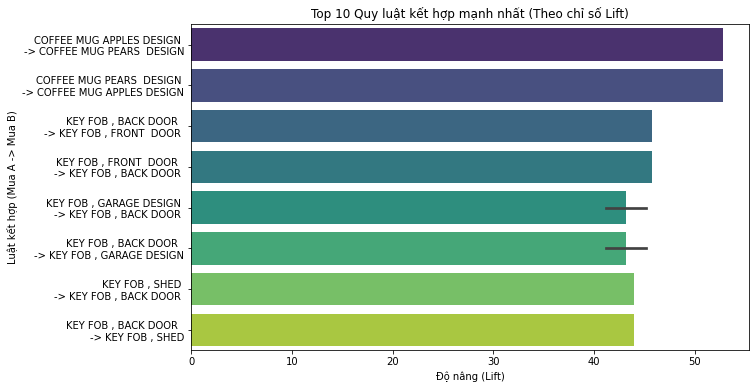

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy top 10 luật có Lift cao nhất (đã chạy ở bước trước)
top_10_rules = top_rules.sort_values(by='lift', ascending=False).head(10)

# Tạo tên ngắn gọn cho luật để vẽ biểu đồ cho đẹp
# Ví dụ: "Cốc Táo -> Cốc Lê"
top_10_rules['rule_name'] = top_10_rules['antecedents'].apply(lambda x: list(x)[0]) + \
                            " \n-> " + \
                            top_10_rules['consequents'].apply(lambda x: list(x)[0])

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='rule_name', data=top_10_rules, palette='viridis')
plt.title('Top 10 Quy luật kết hợp mạnh nhất (Theo chỉ số Lift)')
plt.xlabel('Độ nâng (Lift)')
plt.ylabel('Luật kết hợp (Mua A -> Mua B)')
plt.show()